In [1]:
!pip install -q ultralytics roboflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 59.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 20.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 76.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 132.0 MB/s eta 0:00:00


In [14]:
from roboflow import Roboflow

rf = Roboflow(api_key="Ly77lYwiNcROvraELT76")

project = rf.workspace("khoaluan-nlzdl").project("obj-detection-watermelon")
dataset = project.version(2).download("yolov8")

print("Dataset path:", dataset.location)

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Obj-detection-watermelon-2 in yolov8:: 100%|██████████| 1536/1536 [00:00<00:00, 7877.66it/s]


Dataset path: /content/Obj-detection-watermelon-2


In [15]:
import os
import random
import shutil

# ================== CẤU HÌNH ==================
DATASET_DIR = "/content/Obj-detection-watermelon-2/train"
IMG_DIR = os.path.join(DATASET_DIR, "images")
LABEL_DIR = os.path.join(DATASET_DIR, "labels")

OUTPUT_DIR = "dataset_split"

TRAIN_RATIO = 0.7
VAL_RATIO = 0.2
TEST_RATIO = 0.1

random.seed(42)
# ==============================================

# Lấy danh sách ảnh
images = [f for f in os.listdir(IMG_DIR) if f.endswith(('.jpg', '.png', '.jpeg'))]
random.shuffle(images)

# Tính số lượng
total = len(images)
train_end = int(total * TRAIN_RATIO)
val_end = train_end + int(total * VAL_RATIO)

train_imgs = images[:train_end]
val_imgs = images[train_end:val_end]
test_imgs = images[val_end:]

# Hàm tạo thư mục + copy
def copy_files(image_list, split_name):
    img_out = os.path.join(OUTPUT_DIR, split_name, "images")
    label_out = os.path.join(OUTPUT_DIR, split_name, "labels")

    os.makedirs(img_out, exist_ok=True)
    os.makedirs(label_out, exist_ok=True)

    for img in image_list:
        label = os.path.splitext(img)[0] + ".txt"

        shutil.copy(
            os.path.join(IMG_DIR, img),
            os.path.join(img_out, img)
        )

        shutil.copy(
            os.path.join(LABEL_DIR, label),
            os.path.join(label_out, label)
        )

# Thực hiện chia
copy_files(train_imgs, "train")
copy_files(val_imgs, "valid")
copy_files(test_imgs, "test")

print("Chia dataset xong!")
print(f"Train: {len(train_imgs)} | Valid: {len(val_imgs)} | Test: {len(test_imgs)}")


Chia dataset xong!
Train: 535 | Valid: 153 | Test: 77


In [17]:
import yaml

data = {
    "path": "dataset_split",
    "train": "train/images",
    "val": "valid/images",
    "test": "test/images",
    "nc": 4,
    "names": [
        "Anthracnose",
        "DownyMildew",
        "Healthy",
        "MosaicVirus"
    ]
}

with open("dataset_split/data.yaml", "w") as f:
    yaml.dump(data, f, sort_keys=False)

print("Tạo data.yaml thành công")

Tạo data.yaml thành công


In [2]:
!pip install -q ultralytics

In [18]:
from ultralytics import YOLO

# model = YOLO("yolov8n.pt")
# model.train(
#         data='dataset_split/data.yaml',
#         imgsz=640,
#         epochs=50,
#         batch=32,
#         device=0
#     )
def train_yolov8_optimized():
    model = YOLO("yolov8n.pt")  # pretrained

    model.train(
        data='dataset_split/data.yaml',  # file yaml dataset
        epochs=120,                    # train lâu hơn
        batch=32,                      # nếu hết VRAM -> giảm còn 8
        imgsz=640,                     # ảnh lớn giúp detect tốt hơn
        patience=20,                   # early stopping
        optimizer="AdamW",             # ổn định hơn SGD
        lr0=0.001,                     # learning rate nhỏ → học mịn
        lrf=0.01,                      # LR cuối nhỏ
        momentum=0.9,
        weight_decay=0.0005,

        # 🔹 Data augmentation (rất quan trọng)
        hsv_h=0.015,
        hsv_s=0.7,
        hsv_v=0.4,
        degrees=10,
        translate=0.1,
        scale=0.5,
        shear=2.0,
        flipud=0.0,
        fliplr=0.5,
        mosaic=1.0,
        mixup=0.2,

        # 🔹 Regularization
        label_smoothing=0.05,

        # 🔹 Khác
        device=0,
        workers=2,
        project="runs/detect",
        name="yolov8n_optimized",
        exist_ok=True
    )

train_yolov8_optimized()


WARNING ⚠️ 'label_smoothing' is deprecated and will be removed in the future.
Ultralytics 8.3.247 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=32, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=dataset_split/data.yaml, degrees=10, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=120, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.001, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.2, mode=train, model=yolov8n.pt, momentum=0.9, mosaic=1.0, multi_scale=False, name=yolov8n_optimized, nbs=64, nms=False, opset=None, optimize=False, opti

✅ Columns: ['epoch', 'time', 'train/box_loss', 'train/cls_loss', 'train/dfl_loss', 'metrics/precision(B)', 'metrics/recall(B)', 'metrics/mAP50(B)', 'metrics/mAP50-95(B)', 'val/box_loss', 'val/cls_loss', 'val/dfl_loss', 'lr/pg0', 'lr/pg1', 'lr/pg2']


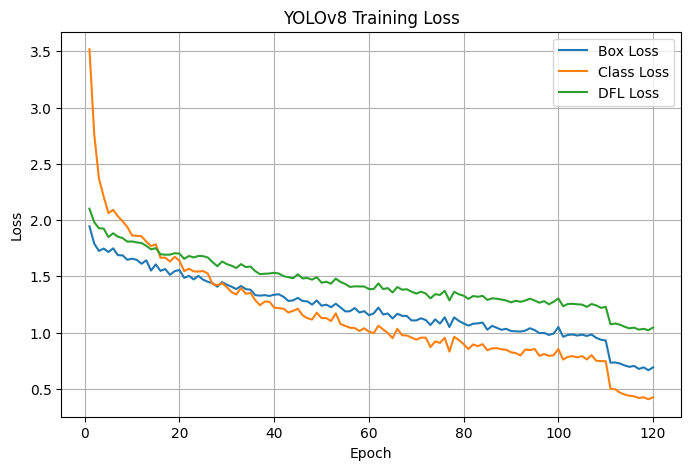

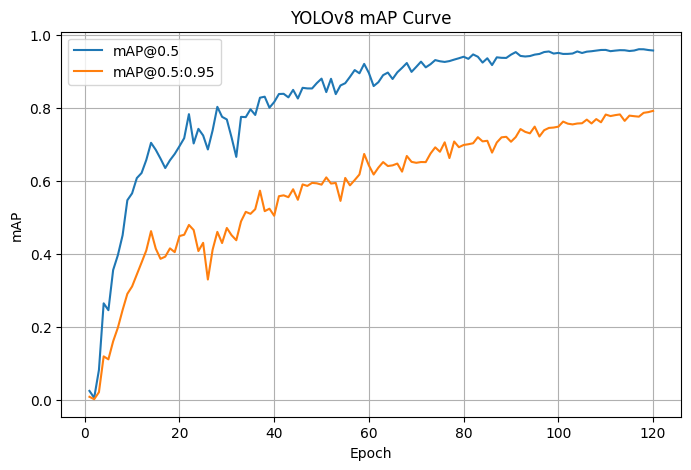

In [20]:
import pandas as pd
import matplotlib.pyplot as plt

# RESULTS_PATH = "/content/runs/detect/train/results.csv"
RESULTS_PATH = "/content/runs/detect/yolov8n_optimized/results.csv"

def load_results(path):
    df = pd.read_csv(path)
    print("✅ Columns:", df.columns.tolist())
    return df


def plot_training_loss(df):
    plt.figure(figsize=(8,5))
    plt.plot(df["epoch"], df["train/box_loss"], label="Box Loss")
    plt.plot(df["epoch"], df["train/cls_loss"], label="Class Loss")
    plt.plot(df["epoch"], df["train/dfl_loss"], label="DFL Loss")

    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("YOLOv8 Training Loss")
    plt.legend()
    plt.grid(True)
    plt.show()


def plot_map(df):
    plt.figure(figsize=(8,5))
    plt.plot(df["epoch"], df["metrics/mAP50(B)"], label="mAP@0.5")
    plt.plot(df["epoch"], df["metrics/mAP50-95(B)"], label="mAP@0.5:0.95")

    plt.xlabel("Epoch")
    plt.ylabel("mAP")
    plt.title("YOLOv8 mAP Curve")
    plt.legend()
    plt.grid(True)
    plt.show()


# ===== MAIN =====
df = load_results(RESULTS_PATH)

plot_training_loss(df)
plot_map(df)

(np.float64(-0.5), np.float64(1919.5), np.float64(1919.5), np.float64(-0.5))

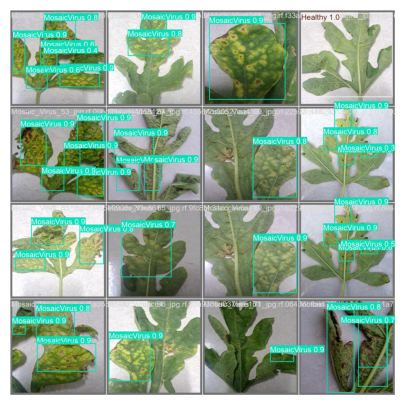

In [21]:
from PIL import Image
import matplotlib.pyplot as plt

# img = Image.open('/content/runs/detect/train/val_batch2_pred.jpg')
img = Image.open('/content/runs/detect/yolov8n_optimized/val_batch2_pred.jpg')
plt.figure(figsize=(5,5))
plt.imshow(img)
plt.axis('off')


In [ ]:
from ultralytics import YOLO

def predict_on_test(model_path, test_image_dir):
    model = YOLO(model_path)
    model.predict(
        source=test_image_dir,
        conf=0.25,
        save=True,
        save_conf=True
    )
predict_on_test(
    model_path='/content/runs/detect/train/weights/best.pt',
    test_image_dir='/content/dataset_split/test/images'
)



image 1/77 /content/dataset_split/test/images/Anthracnose_10_jpg.rf.fe3709c143db136b72ae05add5ce9fcf.jpg: 640x640 1 Anthracnose, 10.2ms
image 2/77 /content/dataset_split/test/images/Anthracnose_20_jpg.rf.a72ae9fb11f54018b0b87287a94c5425.jpg: 640x640 1 Anthracnose, 8.2ms
image 3/77 /content/dataset_split/test/images/Anthracnose_20_jpg.rf.f3de8efae253587f0ab6a805f87db919.jpg: 640x640 1 Anthracnose, 12.1ms
image 4/77 /content/dataset_split/test/images/Anthracnose_22_jpg.rf.58241107295e84c409d980ce6398a542.jpg: 640x640 1 Anthracnose, 9.1ms
image 5/77 /content/dataset_split/test/images/Anthracnose_23_jpg.rf.fe3357e901f5072cb0085d8cfa95477a.jpg: 640x640 1 Anthracnose, 8.6ms
image 6/77 /content/dataset_split/test/images/Anthracnose_27_jpg.rf.6a3b135e92d467a2a39d445958144122.jpg: 640x640 1 Anthracnose, 7.6ms
image 7/77 /content/dataset_split/test/images/Anthracnose_2_jpg.rf.e7e5a530f820b5fa2eb5bfb2ed5c7c21.jpg: 640x640 1 Anthracnose, 7.4ms
image 8/77 /content/dataset_split/test/images/Anthrac

In [22]:
from PIL import Image
import matplotlib.pyplot as plt
import os

def show_test_predictions(n=5):
    pred_dir = '/content/runs/detect/predict'
    imgs = [f for f in os.listdir(pred_dir) if f.endswith('.jpg')]

    for img_name in imgs[:n]:
        img = Image.open(os.path.join(pred_dir, img_name))
        plt.figure(figsize=(5,5))
        plt.imshow(img)
        plt.title(img_name)
        plt.axis('off')
        plt.show()
show_test_predictions(10)


FileNotFoundError: [Errno 2] No such file or directory: '/content/runs/detect/yolov8n_optimized/predict'

Upload ảnh ngoài dataset để test model


Saving Downy_Mildew_60.jpg to Downy_Mildew_60.jpg

image 1/1 /content/Downy_Mildew_60.jpg: 640x480 3 DownyMildews, 11.9ms
Speed: 4.3ms preprocess, 11.9ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 480)
Results saved to /content/runs/detect/predict16


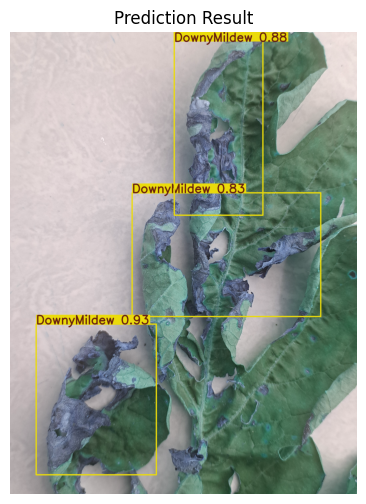

Detection details:
Box 1: Class = DownyMildew, Confidence = 0.93
Box 2: Class = DownyMildew, Confidence = 0.88
Box 3: Class = DownyMildew, Confidence = 0.83


In [28]:
# ====== IMPORT ======
from ultralytics import YOLO
from google.colab import files
import matplotlib.pyplot as plt

# ====== UPLOAD IMAGE ======
print("Upload ảnh ngoài dataset để test model")
uploaded = files.upload()

# Lấy tên ảnh vừa upload
image_path = list(uploaded.keys())[0]
image_path = f"/content/{image_path}"

# ====== LOAD MODEL ======
# model_path = "/content/drive/MyDrive/KhoaLuan/test-3-1-26/detect/train/weights/best.pt"
model_path = "/content/runs/detect/yolov8n_optimized/weights/best.pt"
model = YOLO(model_path)

# ====== PREDICT ======
results = model.predict(
    source=image_path,
    conf=0.25,
    imgsz=640,
    save=True
)

# ====== SHOW IMAGE ======
img = results[0].plot()
plt.figure(figsize=(6,6))
plt.imshow(img)
plt.axis("off")
plt.title("Prediction Result")
plt.show()

# ====== PRINT DETAILS ======
print("Detection details:")
boxes = results[0].boxes
names = results[0].names

if boxes is None:
    print("Không detect được object nào")
else:
    for i in range(len(boxes)):
        cls_id = int(boxes.cls[i])
        conf = float(boxes.conf[i])
        print(f"Box {i+1}: Class = {names[cls_id]}, Confidence = {conf:.2f}")


In [26]:
from google.colab import drive
drive.mount('/content/drive')

import shutil
import os

source_folder = '/content/runs'
destination_folder = '/content/drive/MyDrive/KhoaLuan/test-3-1-26-V2'

shutil.copytree(source_folder, destination_folder, dirs_exist_ok=True)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


'/content/drive/MyDrive/KhoaLuan/test-3-1-26-V2'